## Deep Neural Network model: OHE-PCA
*Summary:* In this notebook, we use DNN models to predict attack/normal labels as well as multi-class attack categories using Principal Component Analysis. We use one-hot encoding for the categorical variables and reduce the dimensionality from a total of 196 features to 18 features, that retain the explanation of 95% of the variance.

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

train = pd.read_csv("../dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv("../dataset/UNSW_NB15_testing-set.csv")

df = pd.concat([train, test]).reset_index(drop=True)
df = df.drop(columns=["id"])
df

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,0,0,0.011000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.000300,254,0,8.810000e+08,0.000000,0,0,0.008000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.005100,254,0,8.544000e+08,0.000000,0,0,0.005000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,0,0,0.006000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.002500,254,0,8.504000e+08,0.000000,0,0,0.010000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,Generic,1
257669,0.505762,tcp,-,FIN,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.98057,3721.068786,120.177727,255,3518776216,3453092386,255,0.09944,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,Shellcode,1
257670,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,Generic,1
257671,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,Generic,1


In [2]:
labels = df['label']
mc_labels = df['attack_cat']
x_df = df.drop(columns=['label', 'attack_cat']).reset_index(drop=True)

### Preprocessing

In [3]:
cat_cols = x_df.select_dtypes(exclude=np.number).columns
num_cols = x_df.select_dtypes(include=np.number).columns

one_hot_cat = []
for cat in cat_cols:
    one_hot_cat.append(pd.get_dummies(x_df[cat]))

x_df = pd.concat([x_df[num_cols]] + one_hot_cat, axis=1)
x_df

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,3pc,a/n,aes-sp3-d,any,argus,aris,arp,ax.25,bbn-rcc,bna,br-sat-mon,cbt,cftp,chaos,compaq-peer,cphb,cpnx,crtp,crudp,dcn,ddp,ddx,dgp,egp,eigrp,emcon,encap,etherip,fc,fire,ggp,gmtp,gre,hmp,i-nlsp,iatp,ib,icmp,idpr,idpr-cmtp,idrp,ifmp,igmp,igp,il,ip,ipcomp,ipcv,ipip,iplt,ipnip,ippc,ipv6,ipv6-frag,ipv6-no,ipv6-opts,ipv6-route,ipx-n-ip,irtp,isis,iso-ip,iso-tp4,kryptolan,l2tp,larp,leaf-1,leaf-2,merit-inp,mfe-nsp,mhrp,micp,mobile,mtp,mux,narp,netblt,nsfnet-igp,nvp,ospf,pgm,pim,pipe,pnni,pri-enc,prm,ptp,pup,pvp,qnx,rdp,rsvp,rtp,rvd,sat-expak,sat-mon,sccopmce,scps,sctp,sdrp,secure-vmtp,sep,skip,sm,smp,snp,sprite-rpc,sps,srp,st2,stp,sun-nd,swipe,tcf,tcp,tlsp,tp++,trunk-1,trunk-2,ttp,udp,unas,uti,vines,visa,vmtp,vrrp,wb-expak,wb-mon,wsn,xnet,xns-idp,xtp,zero,-,dhcp,dns,ftp,ftp-data,http,irc,pop3,radius,smtp,snmp,ssh,ssl,ACC,CLO,CON,ECO,FIN,INT,PAR,REQ,RST,URN,no
0,0.000011,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,0,0,0.011000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0.000008,2,0,1762,0,125000.000300,254,0,8.810000e+08,0.000000,0,0,0.008000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.000005,2,0,1068,0,200000.005100,254,0,8.544000e+08,0.000000,0,0,0.005000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.000006,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,0,0,0.006000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0.000010,2,0,2126,0,100000.002500,254,0,8.504000e+08,0.000000,0,0,0.010000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

PCA allows for dimensionality reduction. We can simply supply the algorithm with the amount of features that we want to reduce to. 
In our case, there are 196 features. We can pass values to the n_components param (e.g., `n_components=10`, will yield 10 features based on the 196 input features). However, choosing `n` arbitrarily is not optimal. So we can set a threshold for the amount of variance that PCA's features produce. Here we set the threshold at 95% and 99%.  

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# apply min-max scaler that scales the variables in the range [0-1]
scl = MinMaxScaler()
scaled_x_df = scl.fit_transform(x_df)
pca = PCA().fit(scaled_x_df)

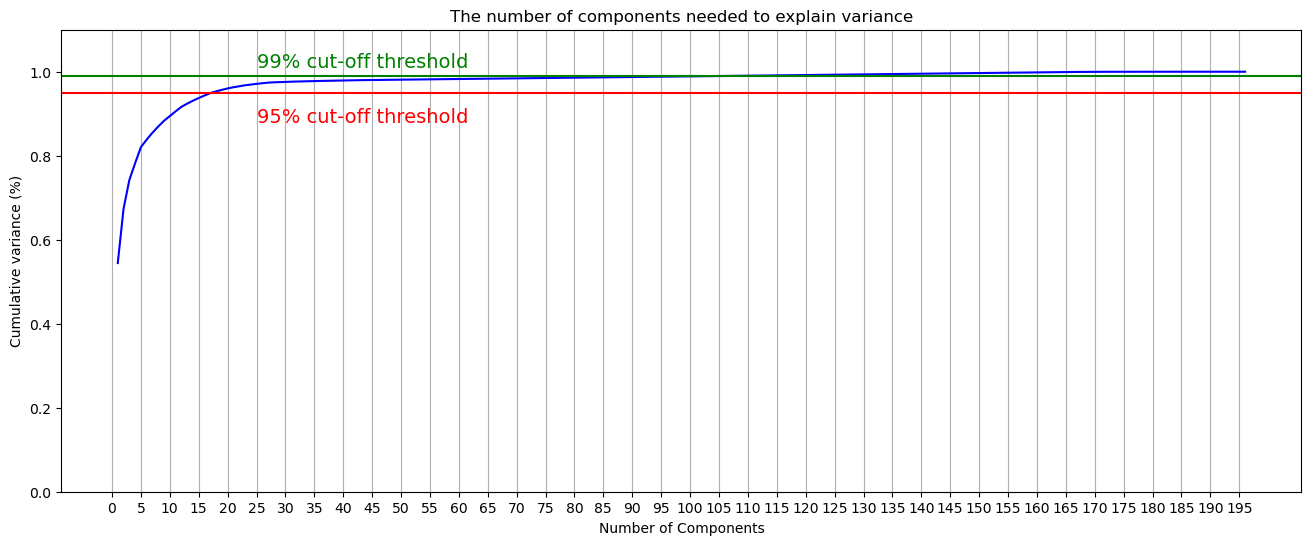

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
xi = np.arange(1, x_df.shape[1]+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.rcParams["figure.figsize"] = (16,6)

plt.ylim(0.0, 1.1)
plt.plot(xi, y, linestyle='-', color='b', markersize=4)

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, x_df.shape[1]+1, step=5))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components in PCA needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(25, 0.88, '95% cut-off threshold', color='red', fontsize=14)

plt.axhline(y=0.99, color='g', linestyle='-')
plt.text(25, 1.01, '99% cut-off threshold', color='green', fontsize=14)

ax.grid(axis='x')
plt.show()

In [7]:
from sklearn.decomposition import PCA

# apply principal component analysis
pca = PCA(n_components=0.95)
pca_df = pca.fit_transform(scaled_x_df)
pca_df = pd.DataFrame(pca_df)

pca_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.139665,0.691133,0.033781,-0.123732,0.159891,-0.523700,-0.322463,-0.037430,0.125500,0.001090,0.038912,0.111895,0.081098,-0.141533,-0.013122,-0.061079,0.092185,-0.099478
1,1.134885,0.697829,0.023619,-0.127989,0.178153,-0.522009,-0.409717,-0.014354,0.170584,0.007360,0.134525,0.286903,0.003883,-0.126337,0.003497,-0.106215,0.080168,-0.062628
2,1.148204,0.691567,0.016223,-0.125080,0.154072,-0.525683,-0.354547,-0.032282,0.147059,0.004373,0.088459,0.203503,0.058159,-0.152448,0.003864,-0.038568,0.046168,-0.013226
3,1.149644,0.685189,0.015876,-0.127804,0.145047,-0.521827,-0.332389,-0.030487,0.133900,0.003557,0.076222,0.186266,0.069142,-0.143479,-0.002248,-0.047803,0.062347,-0.035391
4,1.137643,0.689183,0.014163,-0.136374,0.167205,-0.515563,-0.412557,0.000424,0.171118,0.009367,0.164773,0.351305,-0.014860,-0.108051,0.003248,-0.138290,0.095059,-0.076184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,1.625976,-0.681540,-0.287382,-0.071370,-0.202190,0.038976,0.055435,0.029347,-0.052598,-0.001430,-0.014590,0.004202,-0.014239,0.039169,-0.009705,-0.044267,0.049091,-0.045421
257669,-1.524051,0.238075,-0.484932,-0.461644,0.070493,-0.006903,-0.131525,-0.155011,-0.253907,0.035962,0.178556,-0.217753,-0.037990,-0.010673,-0.001146,-0.053777,-0.016547,0.027020
257670,1.505197,-0.506249,-0.119243,0.017648,0.105110,-0.042891,-0.293114,-0.058227,0.133216,-0.005714,-0.080026,-0.265888,-0.128814,-0.093194,0.010285,-0.008992,0.003542,-0.148684
257671,1.668222,-0.740886,-0.346176,-0.105249,-0.311411,0.064058,0.180714,0.060177,-0.114695,0.000400,0.011547,0.102086,0.027500,0.078313,-0.016644,-0.057298,0.063623,-0.022723


### Binary DNN model

Split the dataset into train, test sets with a test set size of 0.2 of total size 

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pca_df, labels, stratify=labels, test_size=.2, random_state=42)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((206138, 18), (51535, 18), (206138,), (51535,))

We standardize the numerical features to satisfy the assumption that many ML models have on the provided data.

In [9]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test =  pd.DataFrame(sc.transform(X_test))

Split the training set further by using 10000 records as validation samples.

In [10]:
X_val = X_train.iloc[-10000:]
y_val = y_train.iloc[-10000:]

X_train = X_train.iloc[:-10000]
y_train = y_train.iloc[:-10000]

print(f"Training dataset:   {(X_train.shape, y_train.shape)}")
print(f"validation dataset: {(X_val.shape, y_val.shape)}")

Training dataset:   ((196138, 18), (196138,))
validation dataset: ((10000, 18), (10000,))


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [12]:
def create_binary_model():
    model = keras.Sequential(
        [
            layers.Dense(43, activation='relu', input_dim=X_train.shape[1]),
            layers.BatchNormalization(),
            layers.Dropout(rate=0.028454008433744526),
            layers.Dense(25, activation='relu', use_bias=True),
            layers.Dense(90, activation='relu', use_bias=True),
            layers.Dense(1, activation='sigmoid', use_bias=True)
        ]
    )
    model.compile('adam', loss='binary_crossentropy', metrics='accuracy')
    return model

model = create_binary_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 43)                817       
                                                                 
 batch_normalization (BatchN  (None, 43)               172       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 43)                0         
                                                                 
 dense_1 (Dense)             (None, 25)                1100      
                                                                 
 dense_2 (Dense)             (None, 90)                2340      
                                                                 
 dense_3 (Dense)             (None, 1)                 91        
                                                        

In [13]:
import os

checkpoint_path = "../models/model_dnn_b_pca_ohe.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

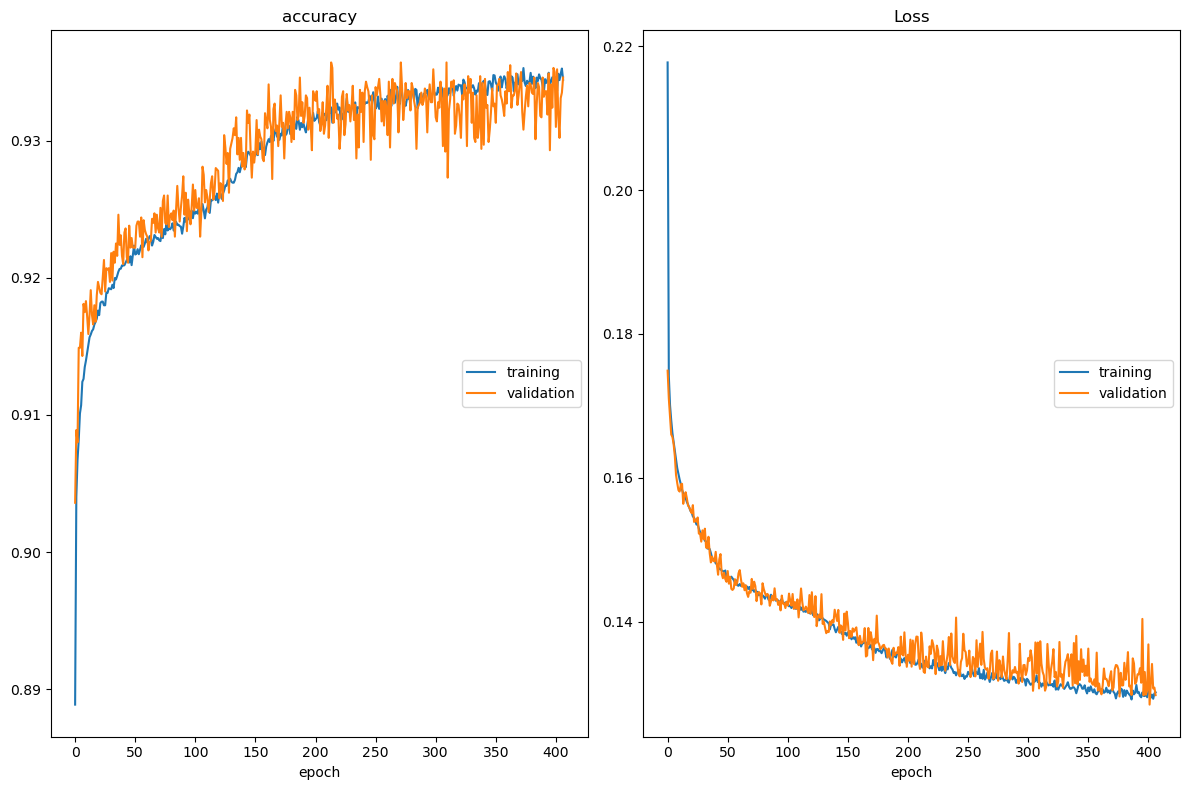

accuracy
	training         	 (min:    0.889, max:    0.935, cur:    0.934)
	validation       	 (min:    0.904, max:    0.936, cur:    0.935)
Loss
	training         	 (min:    0.129, max:    0.218, cur:    0.130)
	validation       	 (min:    0.128, max:    0.175, cur:    0.130)
364/364 - 1s - loss: 0.1302 - accuracy: 0.9344 - val_loss: 0.1298 - val_accuracy: 0.9346 - 1s/epoch - 4ms/step


In [14]:
EPOCHS = 407
BATCH_SIZE = 540

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=BATCH_SIZE)

history = model.fit(X_train,
                    y_train, 
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    verbose=2,
                    callbacks=[PlotLossesKeras(), cp_callback])

In [15]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape((y_pred.shape[0],))

1611/1611 [==============================] - 2s 988us/step


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred.round())
cm = np.around(cm / cm.astype('float').sum(axis=1, keepdims=True), decimals=3)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(list(labels.unique())))

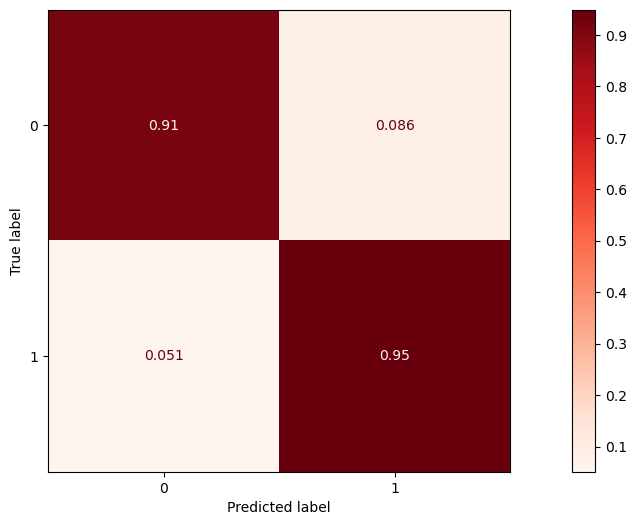

In [17]:
import matplotlib.pyplot as plt

disp.plot(cmap=plt.cm.Reds)

In [18]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, precision_score, f1_score

ys = y_test
ys_pred = y_pred.round()

print(f"Accuracy score:                   {accuracy_score(ys, ys_pred)}")
print(f"Matthews correlation coefficient: {matthews_corrcoef(ys, ys_pred)}")
print(f"recall score (weighted):          {recall_score(ys, ys_pred)}")
print(f"precision score (weighted):       {precision_score(ys, ys_pred)}")
print(f"f1 score (weighted):              {f1_score(ys, ys_pred)}")


Accuracy score:                   0.9361598913359852
Matthews correlation coefficient: 0.8617745517522761
recall score (weighted):          0.9485957188401397
precision score (weighted):       0.9513687992935229
f1 score (weighted):              0.9499802353513547


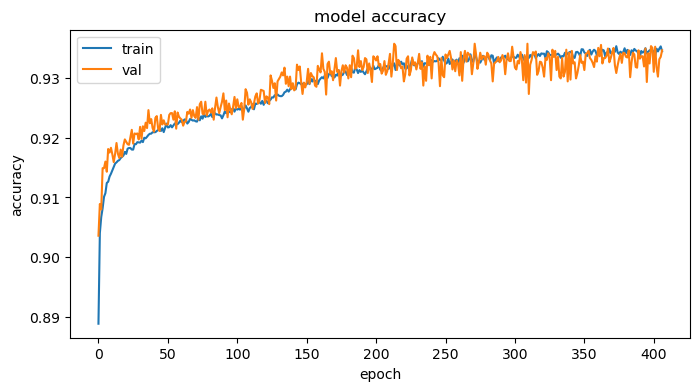

In [19]:
plt.rcParams["figure.figsize"] = (8,4)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

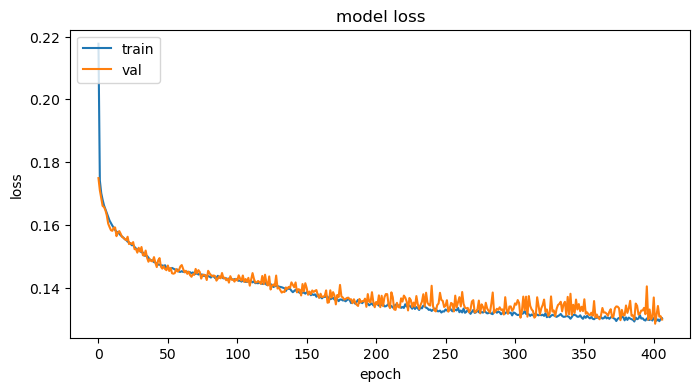

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Multi-class DNN model

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pca_df, pd.get_dummies(mc_labels), stratify=pd.get_dummies(mc_labels), test_size=.2, random_state=42)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((206138, 18), (51535, 18), (206138, 10), (51535, 10))

In [22]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test =  pd.DataFrame(sc.transform(X_test))

In [23]:
X_val = X_train.iloc[-10000:]
y_val = y_train.iloc[-10000:]

X_train = X_train.iloc[:-10000]
y_train = y_train.iloc[:-10000]

print(f"Training dataset:   {(X_train.shape, y_train.shape)}")
print(f"validation dataset: {(X_val.shape, y_val.shape)}")

Training dataset:   ((196138, 18), (196138, 10))
validation dataset: ((10000, 18), (10000, 10))


In [29]:
def create_multiclass_model():
    model = keras.Sequential(
        [
            layers.Dense(27, activation='relu', input_dim=X_train.shape[1]),
            layers.BatchNormalization(),
            layers.Dense(173, activation='relu', use_bias=True),
            layers.Dropout(rate=0.2942475563821516),
            layers.Dense(151, activation='relu', use_bias=True),
            layers.Dense(21, activation='relu', use_bias=True),
            layers.Dense(10, activation='softmax', use_bias=True)
        ]
    )
    model.compile('adam', loss='categorical_crossentropy', metrics='accuracy')
    return model

model = create_multiclass_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 27)                513       
                                                                 
 batch_normalization_3 (Batc  (None, 27)               108       
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 173)               4844      
                                                                 
 dropout_3 (Dropout)         (None, 173)               0         
                                                                 
 dense_16 (Dense)            (None, 151)               26274     
                                                                 
 dense_17 (Dense)            (None, 21)                3192      
                                                      

In [30]:
import os

checkpoint_path = "../models/model_dnn_mc_pca_ohe.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

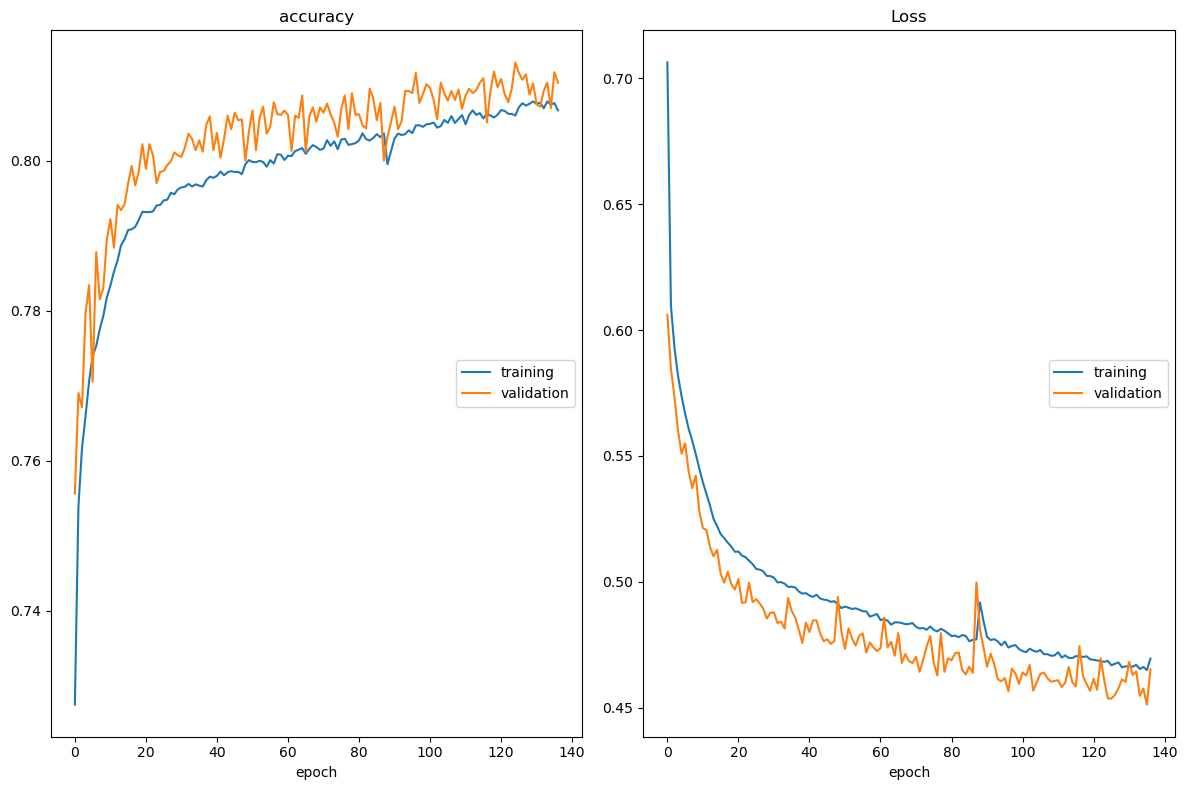

accuracy
	training         	 (min:    0.727, max:    0.808, cur:    0.807)
	validation       	 (min:    0.756, max:    0.813, cur:    0.810)
Loss
	training         	 (min:    0.465, max:    0.706, cur:    0.470)
	validation       	 (min:    0.451, max:    0.606, cur:    0.465)
663/663 - 3s - loss: 0.4695 - accuracy: 0.8067 - val_loss: 0.4653 - val_accuracy: 0.8104 - 3s/epoch - 5ms/step


In [31]:
EPOCHS = 137
BATCH_SIZE = 296

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=BATCH_SIZE)

history = model.fit(X_train,
                    y_train, 
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    verbose=2,
                    callbacks=[PlotLossesKeras(), cp_callback])

In [32]:
y_pred = model.predict(X_test)

1611/1611 [==============================] - 2s 1ms/step


In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test.to_numpy().argmax(axis=1), y_pred.argmax(axis=1))
cm = np.around(cm / cm.astype('float').sum(axis=1, keepdims=True), decimals=3)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(list(mc_labels.unique())))

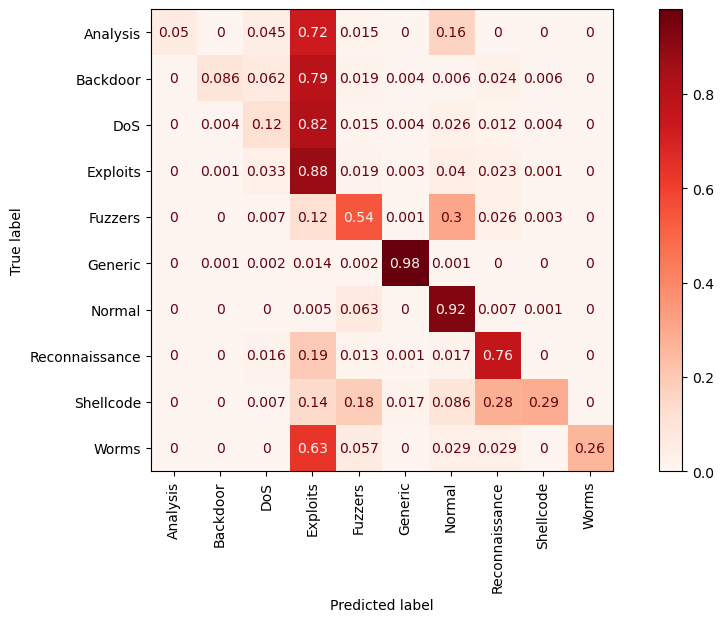

In [34]:
plt.rcParams["figure.figsize"] = (12,6)
disp.plot(cmap=plt.cm.Reds, xticks_rotation=90)

In [35]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, precision_score, f1_score, auc

ys = y_test.to_numpy().argmax(axis=1)
ys_pred = y_pred.argmax(axis=1)

print(f"Accuracy score:                   {accuracy_score(ys, ys_pred)}")
print(f"Matthews correlation coefficient: {matthews_corrcoef(ys, ys_pred)}")
print(f"recall score (weighted):          {recall_score(ys, ys_pred, average='weighted')}")
print(f"precision score (weighted):       {precision_score(ys, ys_pred, average='weighted')}")
print(f"f1 score (weighted):              {f1_score(ys, ys_pred, average='weighted')}")

Accuracy score:                   0.8123217231008053
Matthews correlation coefficient: 0.7571212651856697
recall score (weighted):          0.8123217231008053
precision score (weighted):       0.805659315398922
f1 score (weighted):              0.7921046773736334
